# 0. Import Required Packages

In [192]:
import math
import datetime
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import decomposition, datasets
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold

import warnings
warnings.filterwarnings("ignore")

# 1. Data Wrangling
## 1.1 Predictors

In [116]:
spy = pd.read_csv('./spy.csv', parse_dates=True, index_col=0)
data = pd.read_csv('./research_dataset_2022.csv', parse_dates=True, index_col=0)
data.dropna(subset=['trans_spy_open'], inplace=True)

data['DEF'] = data['BAA'] - data['AAA']
data['TERM'] = data['US10YR'] - data['US3M']
data['VRP'] = data['trans_VIX'] - data['garch']
data['PCR'] = data['trans_spy_open'] / data['trans_SPGSCI']
# the current price versus the past 10 month simple moving average.
data['MA'] = data['trans_spy_open'] / data['trans_spy_open'].rolling(217).mean()

In [117]:
# CAY
X = data[['Consumption_new', 'Income_new']][1800:]; Y = data['Assets_new'][1800:]
LR = LinearRegression().fit(X, Y)
residual = Y - LR.predict(X)
data['CAY'] = [np.nan] * 1800 + residual.to_list()

In [118]:
# OBV
spy['OBV'] = np.nan
spy['OBV'].iloc[0] = spy.iloc[0]['Volume']
for i in range(1,len(spy)):
    if spy.iloc[i]['Close'] > spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] + spy.iloc[i]['Volume']
    elif spy.iloc[i]['Close'] < spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] - spy.iloc[i]['Volume']
    else:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV']
data['OBV'] = np.log(spy['OBV'])

In [119]:
# MOM
data['MOM'] = np.nan
for i in range(len(data)):
    data['MOM'] = data['trans_spy_open'] - data['trans_spy_open'].shift(-3)

In [120]:
var = data[['DividendToPriceRatio', 'trans_PE_RATIO', 'PxToBook', 'CAPE',
            'bbyield', 'DEF', 'TERM', 'CAY', 'SIM', 'VRP', 'IC', 'trans_BDIY',
            'NOS', 'CPI', 'PCR', 'MA', 'OBV', 'MOM', 'SI', 'trans_MVOLE', 
            'BER', 'NAPMPRIC', 'CATY', 'IND_PROD']]
var.rename(columns = {'DividendToPriceRatio':'DP', 'trans_PE_RATIO':'PE',
                      'PxToBook':'BM', 'bbyield':'BY', 'trans_BDIY':'BDI',
                      'trans_MVOLE':'MVOLE', 'IND_PROD':'IP'}, inplace = True)
# Replace NaN Values with Zeros
var = var.fillna(0)

## 1.2 Principle Component

In [121]:
std_slc = StandardScaler()
pca = decomposition.PCA(n_components=1)

# PCA_Price
X_price = var.loc[:, ['DP','PE','BM','CAPE']]
X_price_std = std_slc.fit_transform(X_price)
PCA_price = pca.fit_transform(X_price_std)
var.insert(loc=4, column='PCA_Price', value=PCA_price)

# PCA Tech
X_tech = var.loc[:, ['MA','OBV','MOM']]
X_tech_std = std_slc.fit_transform(X_tech)
PCA_tech = pca.fit_transform(X_tech_std)
var.insert(loc=19, column='PCA_Tech', value=PCA_tech)

var = var.drop(['DP','PE','BM','CAPE', 'MA','OBV','MOM'], axis=1)

## 1.3 Correlation between Predictors

<AxesSubplot:>

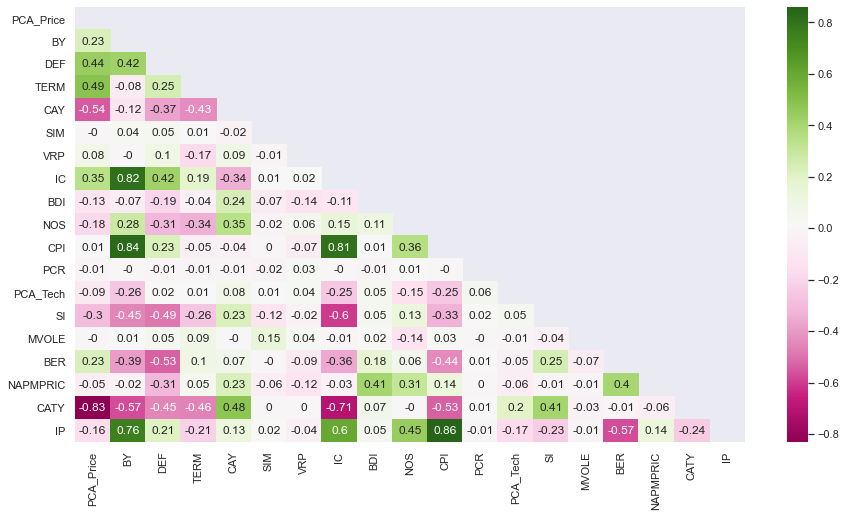

In [122]:
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

## 1.4 PCA to Aviod Multicollinearity

In [123]:
# PCA_Econ
X_econ = var.loc[:, ['BY','IC','CPI','IP']]
X_econ_std = std_slc.fit_transform(X_econ)
PCA_econ = pca.fit_transform(X_econ_std)
var.insert(loc=19, column='PCA_Econ', value=PCA_econ)

# new PCA_Price
var['DP'] = data['DividendToPriceRatio']; var['PE'] = data['trans_PE_RATIO']
var['BM'] = data['PxToBook']; var['CAPE'] = data['CAPE']
X_price_new = var.loc[:, ['DP','PE','BM','CAPE', 'CATY']]
X_price_new_std = std_slc.fit_transform(X_price_new)
PCA_price_new = pca.fit_transform(X_price_new_std)
var.insert(loc=1, column='PCA_Price_New', value=PCA_price_new)

var = var.drop(['BY','IC','CPI','IP', 'DP','PE','BM','CAPE', 'CATY', 'PCA_Price'], axis=1)

<AxesSubplot:>

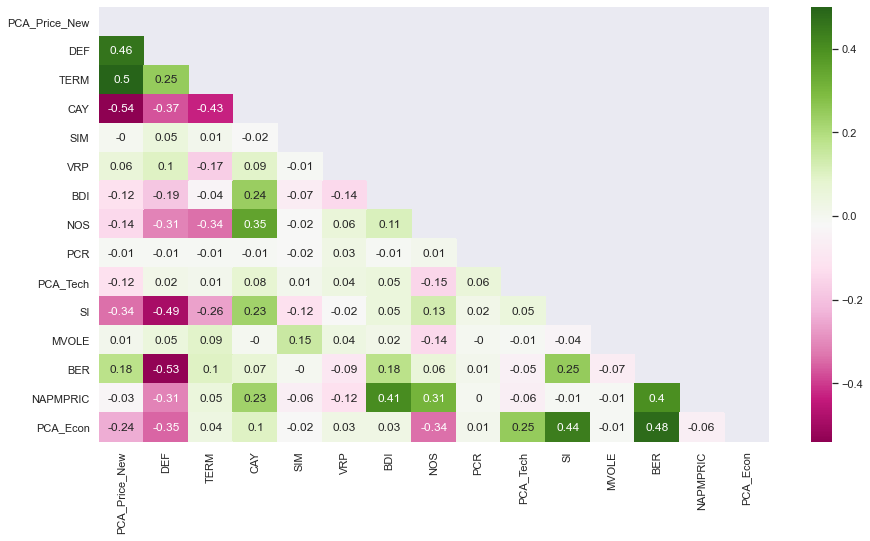

In [124]:
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

## 1.5 Future Returns

In [125]:
def calculate_returns(ndays):
    spy[str(ndays)+'DaysReturn'] = np.nan
    for i in range(len(spy)):
        try:
            present = spy.iloc[i]['Open']
            future = spy.iloc[i+ndays]['Open']
            spy[str(ndays)+'DaysReturn'].iloc[i] = (future - present) / present
        except:
            pass

In [126]:
# 1-month return
calculate_returns(22)
var['1MReturn'] = spy['22DaysReturn']
# 3-month return
calculate_returns(65)
var['3MReturn'] = spy['65DaysReturn']
# 6-month return
calculate_returns(130)
var['6MReturn'] = spy['130DaysReturn']
# 1-year return
calculate_returns(260)
var['1YReturn'] = spy['260DaysReturn']

## 1.6 Correlation between Predictors and Future Returns

In [127]:
oneM = round(var[var.columns].corr()['1MReturn'][:15], 3)
threeM = round(var[var.columns].corr()['3MReturn'][:15], 3)
sixM = round(var[var.columns].corr()['6MReturn'][:15], 3)
oneY = round(var[var.columns].corr()['1YReturn'][:15], 3)
pd.DataFrame({'1MReturn': oneM, '3MReturn': threeM, '6MReturn': sixM, '1YReturn': oneY})

,1MReturn,3MReturn,6MReturn,1YReturn
PCA_Price_New,0.064,0.102,0.161,0.266
DEF,-0.034,-0.053,0.009,0.078
TERM,-0.054,-0.095,-0.078,0.003
CAY,-0.079,-0.160,-0.265,-0.397
SIM,0.072,0.046,-0.008,0.017
VRP,0.046,0.116,0.134,0.104
BDI,0.085,0.069,-0.021,-0.156
NOS,-0.054,-0.130,-0.158,-0.185
PCR,0.016,0.009,0.023,0.008
PCA_Tech,0.177,0.063,0.010,-0.031


# 2. Modeling

In [139]:
# remove NAs in last 260 lines
var = var[:-260]

In [140]:
X = var[var.columns.drop(['1MReturn', '3MReturn', '6MReturn', '1YReturn'])].to_numpy()
Y = var['1YReturn'].to_numpy()

In [143]:
def predict_y(model, y_list, X_set):
    for i in range(int(len(X[2600:])/22)):
        num = i * 22
        X_train = X_set[num:2600+num]; Y_train = Y[num:2600+num]
        X_test = X_set[2600+num:2600+num+22]
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        y_list.extend(y_pred)

## 2.1 Kitchen Sinking Regression

In [147]:
lr = LinearRegression(); lr_pred = []
predict_y(lr, lr_pred, X)

## 2.2 Correlation Screening

In [150]:
X_cs = var[oneY[abs(oneY) > 0.1].index].to_numpy()
cs_pred = []
predict_y(lr, cs_pred, X_cs)

## 2.3 LASSO Regression

In [178]:
X_col = var.columns.drop(['1MReturn', '3MReturn', '6MReturn', '1YReturn'])
X_scaled = std_slc.fit_transform(X)
X_scaled = pd.DataFrame(data = X_scaled, columns = X_col)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0.01, 10, 15)
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
lasso_pred = []
predict_y(lasso, lasso_pred, X_scaled)

## 3. Model Diagnosis

In [197]:
results = pd.DataFrame({'Date': var.index[2600:-5], 'SPY': Y[2600:-5], 'LR': lr_pred, 
                        'CS': cs_pred, 'LASSO': lasso_pred})
results["Date"] = results["Date"].astype("datetime64")
results = results.set_index("Date")
results

,SPY,LR,CS,LASSO
Date,,,,
2003-05-29,0.194305,0.250139,0.259723,0.188610
2003-05-30,0.189155,0.237765,0.256866,0.186457
2003-06-02,0.167026,0.240328,0.269895,0.189626
2003-06-03,0.172414,0.256736,0.269798,0.191074
2003-06-04,0.167315,0.254126,0.268236,0.188838
...,...,...,...,...
2021-01-14,0.157992,0.173165,0.154920,0.175404
2021-01-15,0.163357,0.207845,0.164099,0.192361
2021-01-19,0.143627,0.208440,0.169814,0.196487


In [235]:
linear1 = lr.fit(results['LR'].values.reshape(-1, 1), 
                 results['SPY'].values.reshape(-1, 1))
results['linear1'] = linear1.predict(results['LR'].values.reshape(-1, 1))

linear2 = lr.fit(results['CS'].values.reshape(-1, 1), 
                 results['SPY'].values.reshape(-1, 1))
results['linear2'] = linear1.predict(results['CS'].values.reshape(-1, 1))

linear3 = lr.fit(results['LASSO'].values.reshape(-1, 1), 
                 results['SPY'].values.reshape(-1, 1))
results['linear3'] = linear1.predict(results['LASSO'].values.reshape(-1, 1))

(-0.8, 0.8)

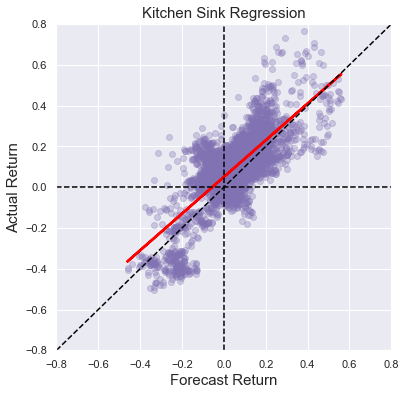

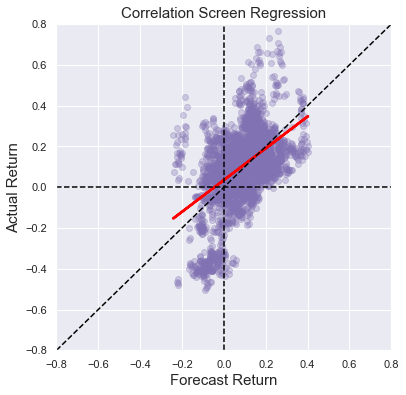

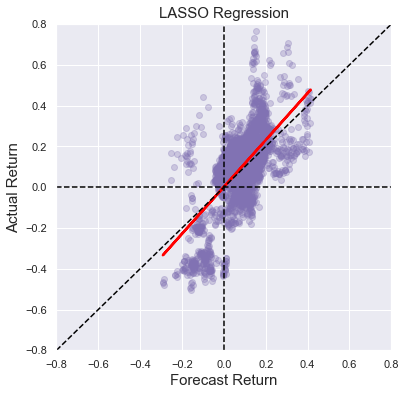

In [256]:
results.plot(x='LR', y='linear1', legend=None, color='red', lw=2.5)
plt.scatter(x=results['LR'].to_list(), y=results['SPY'], color='m', alpha=.3)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axvline(x=0, color='black', linestyle='dashed')
plt.axline([0, 0], [1, 1], color='black', linestyle='dashed')
plt.title('Kitchen Sink Regression', fontsize=15)
plt.xlabel('Forecast Return', fontsize=15)
plt.ylabel('Actual Return', fontsize=15)
plt.gcf().set_size_inches(6, 6)
plt.xlim([-.8, .8])
plt.ylim([-.8, .8])

results.plot(x='CS', y='linear2', legend=None, color='red', lw=2.5)
plt.scatter(x=results['CS'].to_list(), y=results['SPY'], color='m', alpha=.3)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axvline(x=0, color='black', linestyle='dashed')
plt.axline([0, 0], [1, 1], color='black', linestyle='dashed')
plt.title('Correlation Screen Regression', fontsize=15)
plt.xlabel('Forecast Return', fontsize=15)
plt.ylabel('Actual Return', fontsize=15)
plt.gcf().set_size_inches(6, 6)
plt.xlim([-.8, .8])
plt.ylim([-.8, .8])

results.plot(x='LASSO', y='linear3', legend=None, color='red', lw=2.5)
plt.scatter(x=results['LASSO'].to_list(), y=results['SPY'], color='m', alpha=.3)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.axvline(x=0, color='black', linestyle='dashed')
plt.axline([0, 0], [1, 1], color='black', linestyle='dashed')
plt.title('LASSO Regression', fontsize=15)
plt.xlabel('Forecast Return', fontsize=15)
plt.ylabel('Actual Return', fontsize=15)
plt.gcf().set_size_inches(6, 6)
plt.xlim([-.8, .8])
plt.ylim([-.8, .8])